In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout
import pickle
from pathlib import Path
from config import dir_config
from src.decision_models import *

In [3]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

## Helper functions

## import data

In [4]:
with open(Path(processed_dir, 'sessions_metadata.csv'), 'r') as f:
    session_metadata = pd.read_csv(f)

## prepare data

In [5]:

# Pre-allocate lists for session data
behavior_df = pd.DataFrame(columns=["session_id", "prior_direction", "GP_trial_num", "prob_toRF", "signed_coherence", "target", "choice", "outcome","response_time"])


# Process each session
for _, session_row in session_metadata.iterrows():

    session_id = session_row["session_id"]
    prior_direction = "L" if (session_row["prior_direction"] == "toRF" and session_row["RF_side"] == "L") or (session_row["prior_direction"] == "awayRF" and session_row["RF_side"] == "R") else "R"

    # Read trial data for each session
    trial_data = pd.read_csv(Path(compiled_dir, session_id, f"{session_id}_trial.csv"), index_col=None)
    GP_trial_data = trial_data[trial_data.task_type == 1].reset_index()


    # Get valid indices based on outcomes
    valid_idx = np.where((GP_trial_data.outcome >= 0) & (~np.isnan(GP_trial_data.reaction_time.values)))[0]

    coherence = GP_trial_data.coherence.values[valid_idx]
    target = GP_trial_data.target.values[valid_idx].astype(int)
    choices = GP_trial_data.choice.values[valid_idx].astype(int)
    outcomes = GP_trial_data.outcome.values[valid_idx].astype(int)

    if session_row["RF_side"] == "L": # flip target and choice to L/R as 0/1
        target = 1 - target
        choices = 1 - choices

    signed_coherence = coherence * (target * 2 - 1)
    GP_trial_num = np.array(GP_trial_data.trial_number)[valid_idx]
    prob_toRF = np.array(GP_trial_data.prob_toRF)[valid_idx]

    # Check for NaNs or missing values
    if np.isnan(coherence).any():
        print(f"Warning: NaNs found in coherence for session {session_id}")
    if np.isnan(GP_trial_data.reaction_time.values[valid_idx]).any():
        print(f"Warning: NaNs found in reaction_time for session {session_id}")
    if pd.isnull(target).any():
        print(f"Warning: Missing target values for session {session_id}")
    if pd.isnull(choices).any():
        print(f"Warning: Missing choice values for session {session_id}")
    if pd.isnull(outcomes).any():
        print(f"Warning: Missing outcome values for session {session_id}")

    behavior_df = pd.concat([behavior_df, pd.DataFrame({
        "session_id": session_id,
        "prior_direction": prior_direction,
        "GP_trial_num": GP_trial_num,
        "prob_toRF": prob_toRF,
        "signed_coherence": signed_coherence, # range[-100,100]
        "target": target,
        "choice": choices,
        "outcome": outcomes,
        "rt": GP_trial_data.reaction_time.values[valid_idx]/1000 # in sec
    })], ignore_index=True)

behavior_df['prior_block'] = np.where(behavior_df['prob_toRF'] == 50, 'equal', 'unequal')


In [6]:
optimizer_options = {
    'maxiter': 1000,
    'maxls': 50,
    'ftol': 1e-6,
    'gtol': 1e-4,
    'disp': False
}


In [7]:
# break sessions into 5 batches for fitting
n_batches = 15
session_ids = behavior_df['session_id'].unique()
batches = np.array_split(session_ids, n_batches)
batches

[array(['210126_GP_JP', '210205_GP_JP', '210210_GP_JP'], dtype=object),
 array(['210211_GP_JP', '210217_GP_JP', '210224_GP_JP'], dtype=object),
 array(['210302_GP_JP', '210305_GP_JP', '210311_GP_JP'], dtype=object),
 array(['210312_GP_JP', '210315_GP_JP', '210316_GP_JP'], dtype=object),
 array(['210317_GP_JP', '210318_GP_JP', '210323_GP_JP'], dtype=object),
 array(['210413_GP_JP', '210524_GP_JP', '210525_GP_JP'], dtype=object),
 array(['210528_GP_JP', '210601_GP_JP', '210602_GP_JP'], dtype=object),
 array(['210603_GP_JP', '210608_GP_JP', '210609_GP_JP'], dtype=object),
 array(['210708_GP_JP', '240625_GP_TZ', '240627_GP_TZ'], dtype=object),
 array(['240710_GP_TZ', '240805_GP_TZ', '240809_GP_TZ'], dtype=object),
 array(['240814_GP_TZ', '240828_GP_TZ', '240903_GP_TZ'], dtype=object),
 array(['241002_GP_TZ', '241129_GP_TZ', '241130_GP_TZ'], dtype=object),
 array(['241209_GP_TZ', '241211_GP_TZ', '241216_GP_TZ'], dtype=object),
 array(['241217_GP_TZ', '241223_GP_TZ', '241227_GP_TZ'], dtype=o

In [8]:
enable_leak=False
enable_time_dependence = False
for idx_batch, batch in enumerate(batches):
    models, results = [], []
    for session_id in batch:
        print(f"Fitting session {session_id}...")
        data = behavior_df[(behavior_df.session_id == session_id)]
        data = data[["signed_coherence", "choice", "rt", "prior_block"]].reset_index(drop=True)
        data["choice"] = data["choice"].astype(int)

        # # Get stimulus length
        stimulus_length = int(np.max(data["rt"]) * 1000)
        stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100  # range[-1,1]

        model = DecisionModel(enable_leak=enable_leak, enable_time_dependence=enable_time_dependence, device="cuda")

        result = model.fit(data, stimulus, optimizer_options=optimizer_options)

        models.append(model)
        results.append(result)
        print(f"Finished fitting session {session_id}. Optimizer success: {result.success}. Message: {result.message}")

    break
    # with open(Path(processed_dir, f"ddm_batch_{idx_batch}_fit.pkl"), "wb") as f:
    #     pickle.dump({"models": models, "results": results, "session_ids": batch}, f)

Fitting session 210126_GP_JP...
Stage 0: Global search...
Stage 1: Powell refinement...
Optimization terminated successfully.
         Current function value: 0.030024
         Iterations: 2
         Function evaluations: 326
Stage 2: L-BFGS-B fine-tuning...
Finished fitting session 210126_GP_JP. Optimizer success: True. Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Fitting session 210205_GP_JP...
Stage 0: Global search...


KeyboardInterrupt: 

In [ ]:
model_results = {}
for batch_idx in range(n_batches):
    print(f"Loading results for batch {batch_idx}...")
    with open(Path(processed_dir, f'ddm_batch_{batch_idx}_fit.pkl'), 'rb') as f:
        batch_data = pickle.load(f)
    for session_id, model, result in zip(batch_data['session_ids'], batch_data['models'], batch_data['results']):
        model_results[session_id] = {'model': model, 'result': result}

In [ ]:
params = []
for session in model_results.keys():
    params.append(model_results[session]["result"].x)
params = np.array(params)

In [ ]:
mean_params = np.mean(params, axis=0)
std_params = np.std(params, axis=0)
param_names = model_results[session]["model"].all_params.keys()
param_bounds = model_results[session]["model"].all_params

In [ ]:
for param_name, mean_param, std_param in zip(param_names, mean_params, std_params):
    bound = model_results[session]["model"].all_params[param_name][1]
    plt.bar(param_name, mean_param, label=param_name)
    plt.errorbar(param_name, mean_param, yerr=std_param, fmt='o', color='r')
    plt.ylim(bound)
    plt.title(f'Parameter: {param_name}, Mean: {mean_param:.4f}, Bounds: {bound}')
    plt.legend()
    plt.show()


In [ ]:
for session_idx, session in enumerate(np.unique(behavior_df.session_id)):
    print(f"Fitting session {session}")
    data = behavior_df[(behavior_df.session_id == session)]
    data = data[["signed_coherence", "choice", "rt", "prior_block"]]
    data['choice'] = data['choice'].astype(int)

    # # Get stimulus length
    stimulus_length = int(np.max(data["rt"])*1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length))/100  # range[-1,1]
    plot_ddm_fit(model_results[session]["model"], data, stimulus, model_results[session]["result"], enable_leak=enable_leak, enable_time_dependence=enable_time_dependence)
    break


In [9]:

def simulate_ddm(idx_prior, model, result, stimulus, enable_leak=enable_leak, enable_time_dependence=enable_time_dependence):
    ddm = DriftDiffusionSimulator()
    # Map params into simulator
    for name, value in zip(model.all_params, result.x):
        if name.endswith("_1") and idx_prior == 0:
            base_name = name[:-2]
            setattr(ddm, base_name, value)
        elif name.endswith("_2") and idx_prior == 1:
            base_name = name[:-2]
            setattr(ddm, base_name, value)
        else:
            setattr(ddm, name, value)

        if name == "leak_rate" and not enable_leak:
            setattr(ddm, name, 0.0)
        if name == "time_constant" and not enable_time_dependence:
            setattr(ddm, name, 0.0)

        if (name.endswith("_1") and idx_prior == 0) or (name.endswith("_2") and idx_prior == 1):
            print(f"{base_name}: {getattr(ddm, base_name)}")
        elif name.endswith("_1") or name.endswith("_2"):
            continue
        else:
            print(f"{name}: {getattr(ddm, name)}")

    # Simulate trials
    rt, choice, dv = ddm.simulate_trials(stimulus)

    # Create DataFrame of simulated data
    model_sim = pd.DataFrame(
        {
            "signed_coherence": stimulus[:,0]*100,
            "choice": choice.flatten(),
            "rt": rt.flatten(),
        }
    )
    return model_sim

In [10]:
def plot_ddm_fit(model_sim, data):
    # Get psychometric and chronometric data for both real and simulated data
    x_data, y_data = get_psychometric_data(data)
    _, rt_median, rt_mean, rt_sd, _ = get_chronometric_data(data)
    x_model, y_model = get_psychometric_data(model_sim)
    _, rt_median_model, rt_mean_model, rt_sd_model, _ = get_chronometric_data(model_sim)

    # Plotting
    fig = plt.figure(figsize=(12, 10))
    gs = gridspec.GridSpec(2, 2)

    # Psychometric plot (proportion choice)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(x_data, y_data, "o", color="k", label="data")
    ax1.plot(x_model, y_model, "o", color="b", label="model")
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend()

    # Chronometric plot (RT means)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x_data, rt_mean, "o", color="k", label="data")
    ax2.fill_between(x_data, rt_mean - rt_sd, rt_mean + rt_sd, color="k", alpha=0.2)
    ax2.fill_between(x_model, rt_mean_model - rt_sd_model, rt_mean_model + rt_sd_model, color="b", alpha=0.2)
    ax2.plot(x_model, rt_mean_model, "o", color="b", label="model", markersize=8)
    ax2.legend()

    # ax3 = fig.add_subplot(gs[1, :])
    # ax3.plot(dv.T, color="k", alpha=0.1)

    plt.tight_layout()
    plt.show()

    # Print proportion of invalid trials (NaN choices)
    print("Proportion of invalid trials:", np.mean(np.isnan(model_sim["choice"])))

    # return model_sim, ddm


Fitting session 210126_GP_JP
ndt: 0.10002644278454076
drift_gain: 1.001256032265686
variance: 0.1003239241106243
a: 0.8003437561990299
z: 0.10005288556908153
drift_offset: 0.0
Session: 210126_GP_JP, Prior: equal


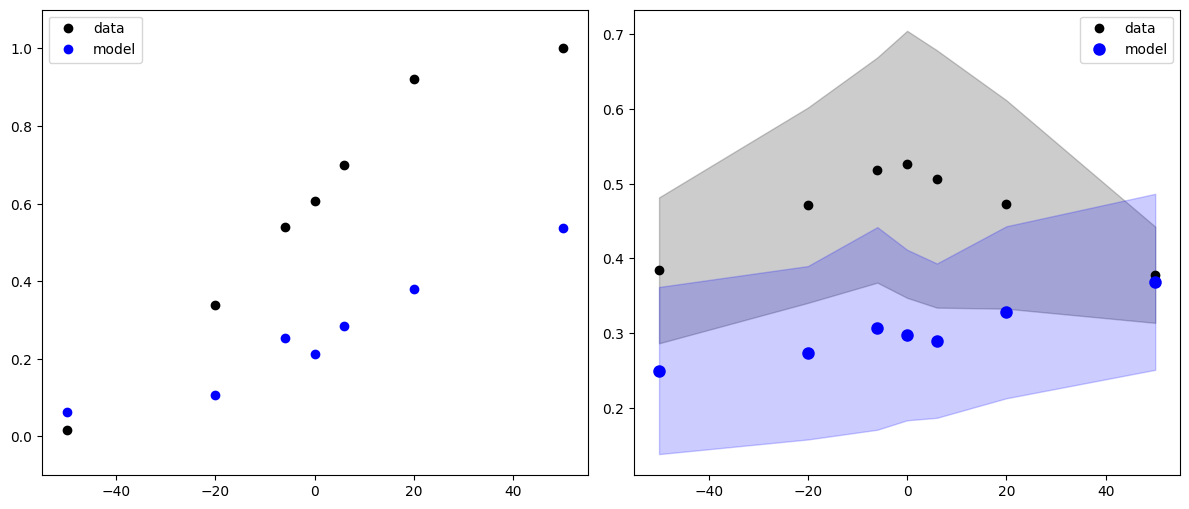

Proportion of invalid trials: 0.0
ndt: 0.10002644278454076
drift_gain: 1.001256032265686
variance: 0.1003239241106243
a: 0.8003437561990299
z: 0.10005288556908153
drift_offset: 0.0
Session: 210126_GP_JP, Prior: unequal


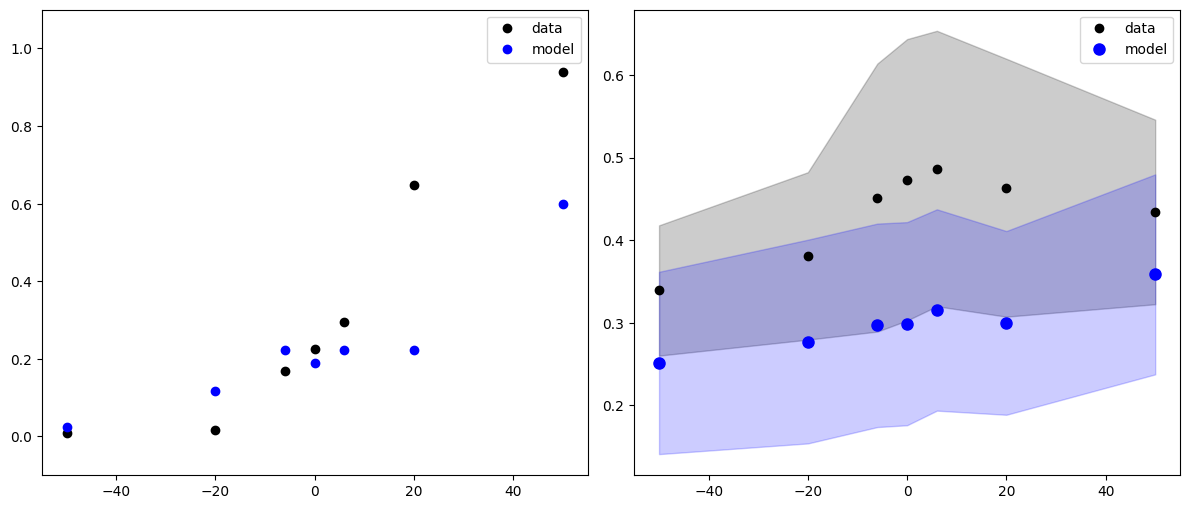

Proportion of invalid trials: 0.0
Fitting session 210205_GP_JP


IndexError: list index out of range

In [11]:
for session_idx, session in enumerate(np.unique(behavior_df.session_id)):
    print(f"Fitting session {session}")
    data = behavior_df[(behavior_df.session_id == session)]
    data = data[["signed_coherence", "choice", "rt", "prior_block"]]
    data["choice"] = data["choice"].astype(int)

    # # Get stimulus length
    stimulus_length = int(np.max(data["rt"]) * 1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100  # range[-1,1]
    for prior in ["equal", "unequal"]:
        prior_stimulus = stimulus[data["prior_block"] == prior]
        model_sim = simulate_ddm(0 if prior == "equal" else 1, models[session_idx], results[session_idx], prior_stimulus, enable_leak=enable_leak, enable_time_dependence=True)
        print(f"Session: {session}, Prior: {prior}")

        plot_ddm_fit(model_sim, data[data["prior_block"] == prior])


In [ ]:
for session_idx, session in enumerate(np.unique(behavior_df.session_id)):
    print(f"Fitting session {session}")
    data = behavior_df[(behavior_df.session_id == session)]
    data = data[["signed_coherence", "choice", "rt", "prior_block"]]
    data["choice"] = data["choice"].astype(int)

    # # Get stimulus length
    stimulus_length = int(np.max(data["rt"]) * 1000)
    stimulus = np.tile(data["signed_coherence"].to_numpy().reshape(-1, 1), (1, stimulus_length)) / 100  # range[-1,1]
    for prior in ["equal", "unequal"]:
        prior_stimulus = stimulus[data["prior_block"] == prior]
        model_sim = simulate_ddm(0 if prior == "equal" else 1,
                                 model_results[session]["model"],
                                 model_results[session]["result"],
                                 prior_stimulus,
                                 enable_leak=enable_leak,
                                 enable_time_dependence=False)
        print(f"Session: {session}, Prior: {prior}")

        plot_ddm_fit(model_sim, data[data["prior_block"] == prior])
    break

In [ ]:
model_sim